In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koushalsanjaymodi","key":"08f98bce9fb8eb0c3626fc71db0aa6f7"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 791M/812M [00:02<00:00, 259MB/s]
100% 812M/812M [00:04<00:00, 191MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
"""
cats_vs_dogs_small:
train: cats (1000) and dogs (1000)
val: cats (500) and dogs (500)
test: cats (1000) and dogs (1000)
"""

'\ncats_vs_dogs_small:\ntrain: cats (1000) and dogs (1000)\nval: cats (500) and dogs (500)\ntest: cats (1000) and dogs (1000)\n'

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [8]:
from tensorflow.keras import layers
from tensorflow import keras

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
# Option 1: Run the convolutional base over our dataset (will miss on augmentation)
# Option 2: Extend the model we have (conv_base) by adding Dense layers on top and run the the whole thing from end to end on the input data.

conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False
)

conv_base.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [12]:
import matplotlib.pyplot as plt

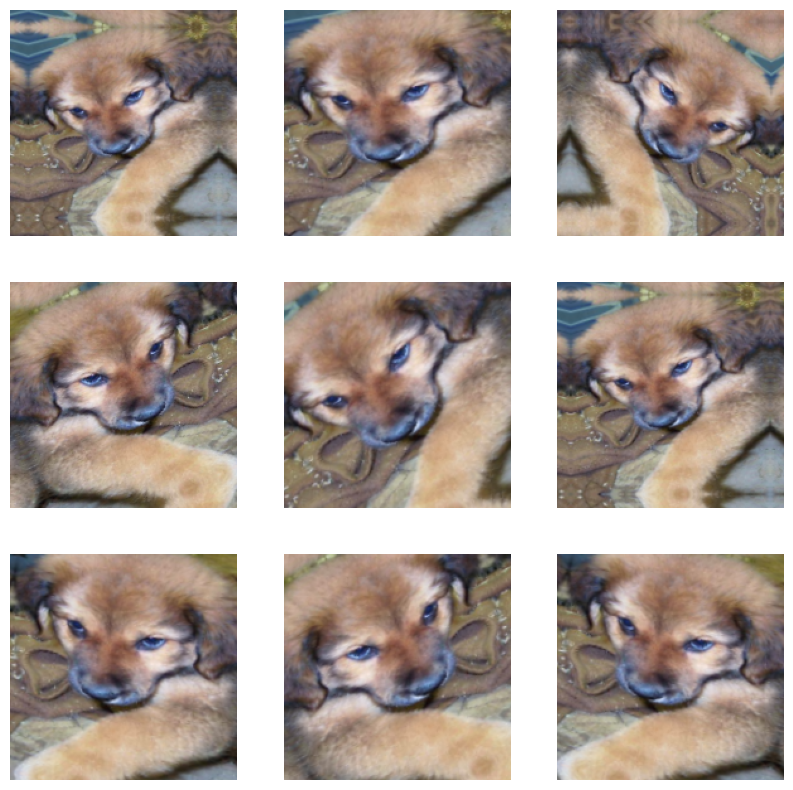

In [17]:
plt.figure(figsize = (10,10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation= "sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_with_data_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

In [24]:
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.8230 - loss: 47.0162 - val_accuracy: 0.9700 - val_loss: 3.5385
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9453 - loss: 6.2798 - val_accuracy: 0.9660 - val_loss: 5.8729
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9553 - loss: 6.1193 - val_accuracy: 0.9700 - val_loss: 4.4872
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.9583 - loss: 6.0986 - val_accuracy: 0.9580 - val_loss: 10.3456
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.9610 - loss: 6.3877 - val_accuracy: 0.9660 - val_loss: 5.6971
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9634 - loss: 3.8786 - val_accuracy: 0.9710 - val_loss: 5.2029
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9709 - loss: 3.6552 - val_accuracy: 0.9730 - val_loss: 4.5305
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9702 - loss: 3.3011 - val_ac

In [25]:
history_dict = history.history

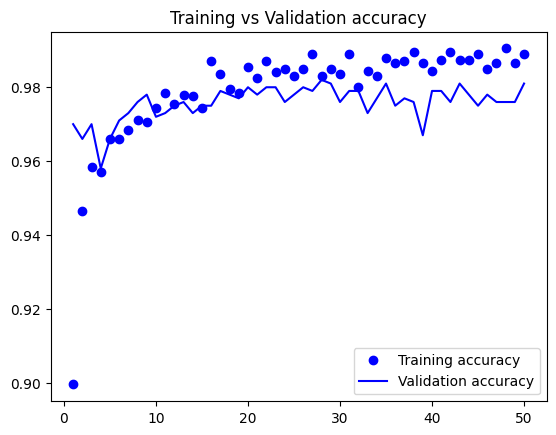

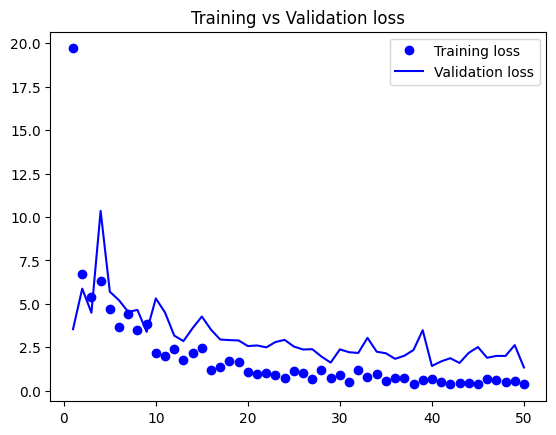

In [26]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Training accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.legend()
plt.title("Training vs Validation loss")
plt.show()

In [29]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9727 - loss: 2.6670
Test accuracy: 0.974


In [31]:
import numpy as np
best_epoch_val_acc = np.argmax(val_acc) + 1
print(best_epoch_val_acc)

best_epoch_val_loss = np.argmin(val_loss) + 1
print(best_epoch_val_loss)

28
50
